In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import gc
import glob
import random
from tqdm import tqdm
import optuna
import gc
from pathlib import Path
import torch
import torch.nn as nn
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import numpy.matlib
# import pytablewriter

In [2]:
nn.CrossEntropyLoss()(torch.tensor([[1., 0., 0., 0.]]), torch.tensor([0]))

tensor(0.7437)

In [3]:
DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
OOF_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs")
OOF_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs_stacking")

OUTPUT_DIR = Path('./output/')

In [7]:
df = pd.read_csv(DATA_DIR / 'train.csv')
df['R_C'] = [f'{r}_{c}' for r, c in zip(df['R'], df['C'])]
unique_pressures = df["pressure"].unique()
df_ = df[df['u_out'] == 0].reset_index(drop=True)

#cs = df['C'].unique()
#rs = df['R'].unique()
u_out = df['u_out'].values
targets = df['pressure'].values[u_out == 0]
rs = df_['R'].values

In [8]:
paths = [
        str(OOF_DIR / 'tea_oof_cv0.16608165493383653.csv'),
         str(OOF_DIR / 'tea_oof_cv0.16852467380720984.csv'),
         str(OOF_DIR / 'rt4kaido_oof_total_75.csv'),
         str(OOF_DIR / 'yyama_oof_exp070.npy'),
         str(OOF_DIR / 'rt4kaido_oof_total_77.csv'),
         str(OOF_DIR / 'currypurin_177_oof.npy'),
         str(OOF_DIR / 'currypurin_179_oof.npy'),
         str(OOF_DIR / 'rt2kaido_oof_exp75_10folds.npy'),
         str(OOF_DIR / 'yyama_oof_exp080.npy'),
         str(OOF_DIR / 'tea_oof_cv0.15402163834314866.csv'),
         str(OOF_DIR / 'tea_oof_cv0.14631403817163816.csv'),
         str(OOF_DIR / 'yyama_oof_exp081.npy'),
         str(OOF_DIR / 'rt4kaido_oof_total_85.csv'),
         str(OOF_DIR / 'currypurin_187_oof.npy'),
         str(OOF_DIR / 'yyama_oof_total_exp75_3.csv'),
         str(OOF_DIR / 'currypurin_190_oof.npy'),
#          str(OOF_DIR / 'rt4kaido_oof_total_88_10fold.csv'),

        ]

paths = [
        str(OOF_DIR / 'tea_stacking_v1_oof_cv0.1232.npy'),
         str(OOF_DIR / 'tea_stacking_v2_oof_cv0.1230.npy'),
         str(OOF_DIR / 'tea_stacking_v3_oof_cv0.1209.npy'),
         str(OOF_DIR / 'yyama_stacking_v7_oof_cv0.1226.npy'),
         str(OOF_DIR / 'yyama_stacking_v8_oof_cv0.1220.npy'),
         str(OOF_DIR / 'currypurin_177_oof.npy'),
        ]

oofs = []
scores = []
scores5 = []
scores20 = []
scores50 = []
for path in paths:
    if '.csv' in path:
        try:
            oof_ = pd.read_csv(path, usecols=['pred'])[u_out == 0].reset_index(drop=True).values.reshape(-1)
            
        except:
            oof_ = pd.read_csv(path, usecols=['oof'])[u_out == 0].reset_index(drop=True).values.reshape(-1)
            print(type(oof_))
    else:
        try:
            oof_ = np.load(path)[df['u_out'] == 0].reshape(-1)
        except:
            oof_ = np.load(path).reshape(-1)[df['u_out'] == 0]
    print(f'loaded {path}')
    #print(type(oof_))
    #print(oof_.shape)
    score = mae(targets, oof_)
    scores.append(score)
    print(score)
    for r in [5,20,50]:
        score = mae(targets[rs==r], oof_[rs==r])
        print('R', r, ':', score)
        if r == 5:
            scores5.append(score)
        if r == 20:
            scores20.append(score)
        if r == 50:
            scores50.append(score)
    print('')
    oofs.append(oof_)
print('preparation done!')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2290968 but corresponding boolean dimension is 6036000

In [6]:
result = pd.DataFrame()
result['path'] = paths
result['path'] = result['path'].apply(lambda x: x.split('/')[-1])
result['cv'] = scores
result['cv'] = result['cv'].apply(lambda x: round(x, 5))
#result['w'] = study.best_params.values()
result['R5'] = scores5
result['R5'] = result['R5'].apply(lambda x: round(x, 5))
result['R20'] = scores20
result['R20'] = result['R20'].apply(lambda x: round(x, 5))
result['R50'] = scores50
result['R50'] = result['R50'].apply(lambda x: round(x, 5))
result['r50_cv_ratio'] = result['R50'] / result['cv']
result['r50_cv_ratio'] = result['r50_cv_ratio'].apply(lambda x: round(x, 3))
display(result)

,path,cv,R5,R20,R50,r50_cv_ratio
0,tea_oof_cv0.16608165493383653.csv,0.16608,0.12653,0.15653,0.20442,1.231
1,tea_oof_cv0.16852467380720984.csv,0.16852,0.12844,0.15768,0.20815,1.235
2,rt4kaido_oof_total_75.csv,0.14743,0.10843,0.13764,0.18547,1.258
3,yyama_oof_exp070.npy,0.14751,0.10979,0.14167,0.18191,1.233
4,rt4kaido_oof_total_77.csv,0.14756,0.10782,0.13847,0.18575,1.259
5,currypurin_177_oof.npy,0.15518,0.11740,0.14676,0.19133,1.233
6,currypurin_179_oof.npy,0.14824,0.10740,0.13990,0.18681,1.260
7,rt2kaido_oof_exp75_10folds.npy,0.13950,0.10187,0.13150,0.17525,1.256
8,yyama_oof_exp080.npy,0.14948,0.11149,0.14344,0.18422,1.232
9,tea_oof_cv0.15402163834314866.csv,0.15402,0.11584,0.14345,0.19193,1.246


In [7]:
print("the number of oof is", len(oofs))

# medianでブレンドする
oof_mean = sum(oofs) / len(oofs)
print('simple mean cv:',mae(targets, oof_mean))

# medianでブレンドする
oof_median = np.median(np.vstack(oofs),axis=0)
print('simple median cv:',mae(targets, oof_median))

# median pp
oof = pd.DataFrame({'pred': oof_median})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
score = mae(targets, oof_pp)
print(score)

the number of oof is 16
simple mean cv: 0.1284126423377514
simple median cv: 0.12445581789121203
0.12190823131924672


In [8]:
oofs = np.array(oofs)

In [9]:
oof_df = pd.DataFrame(oofs.T, columns=[f'oof_{str(i)}' for i in range(oofs.shape[0])])

In [10]:
oof_df = pd.concat([df_, oof_df], axis=1)

In [11]:
oof_df_b_ids = oof_df['breath_id'].unique()

In [14]:
oof_df['median'] = np.median(oof_df.loc[:, 'oof_0':'oof_15'], axis=1)
oof_df['mean'] = np.mean(oof_df.loc[:, 'oof_0':'oof_15'], axis=1)

In [30]:
oof_df

,id,breath_id,R,C,time_step,u_in,u_out,pressure,R_C,oof_0,...,oof_8,oof_9,oof_10,oof_11,oof_12,oof_13,oof_14,oof_15,median,mean
0,1,1,20,50,0.000000,0.083334,0,5.837492,20_50,5.825936,...,5.776286,5.808908,5.798063,5.868944,5.784706,5.903346,5.895987,5.868830,5.856027,5.945587
1,2,1,20,50,0.033652,18.383041,0,5.907794,20_50,5.765423,...,5.852838,5.905727,5.848358,5.877565,5.817481,5.912168,6.107488,5.866003,5.875511,5.893875
2,3,1,20,50,0.067514,22.509278,0,7.876254,20_50,7.723685,...,7.893561,7.914346,7.790454,7.873539,7.859506,8.184838,8.506552,8.075563,7.903953,8.111380
3,4,1,20,50,0.101542,22.808822,0,11.742872,20_50,11.837408,...,11.892482,11.722112,11.766545,11.914234,11.914021,12.292066,12.863997,12.167562,11.914128,12.096092
4,5,1,20,50,0.135756,25.355850,0,12.234987,20_50,12.534660,...,12.380159,12.275325,12.218771,12.443951,12.533509,12.780018,13.025760,12.675638,12.488730,12.547826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290963,6035946,125749,50,10,0.834147,1.869367,0,29.459013,50_10,29.617640,...,29.545875,29.506714,29.559149,29.694087,29.457191,29.523504,29.464153,29.491537,29.485913,29.485256
2290964,6035947,125749,50,10,0.867574,2.154414,0,29.107502,50_10,29.234612,...,29.167386,29.187830,29.225697,29.320322,29.134033,29.196194,29.105743,29.141104,29.119888,29.123454
2290965,6035948,125749,50,10,0.900917,1.304434,0,29.880825,50_10,29.932322,...,29.926865,29.927032,30.003416,30.052200,29.879570,29.925606,29.846693,29.904215,29.881452,29.875283
2290966,6035949,125749,50,10,0.934309,1.733830,0,29.388710,50_10,29.535088,...,29.450082,29.402269,29.511444,29.547284,29.461926,29.452351,29.390806,29.366228,29.396537,29.396128


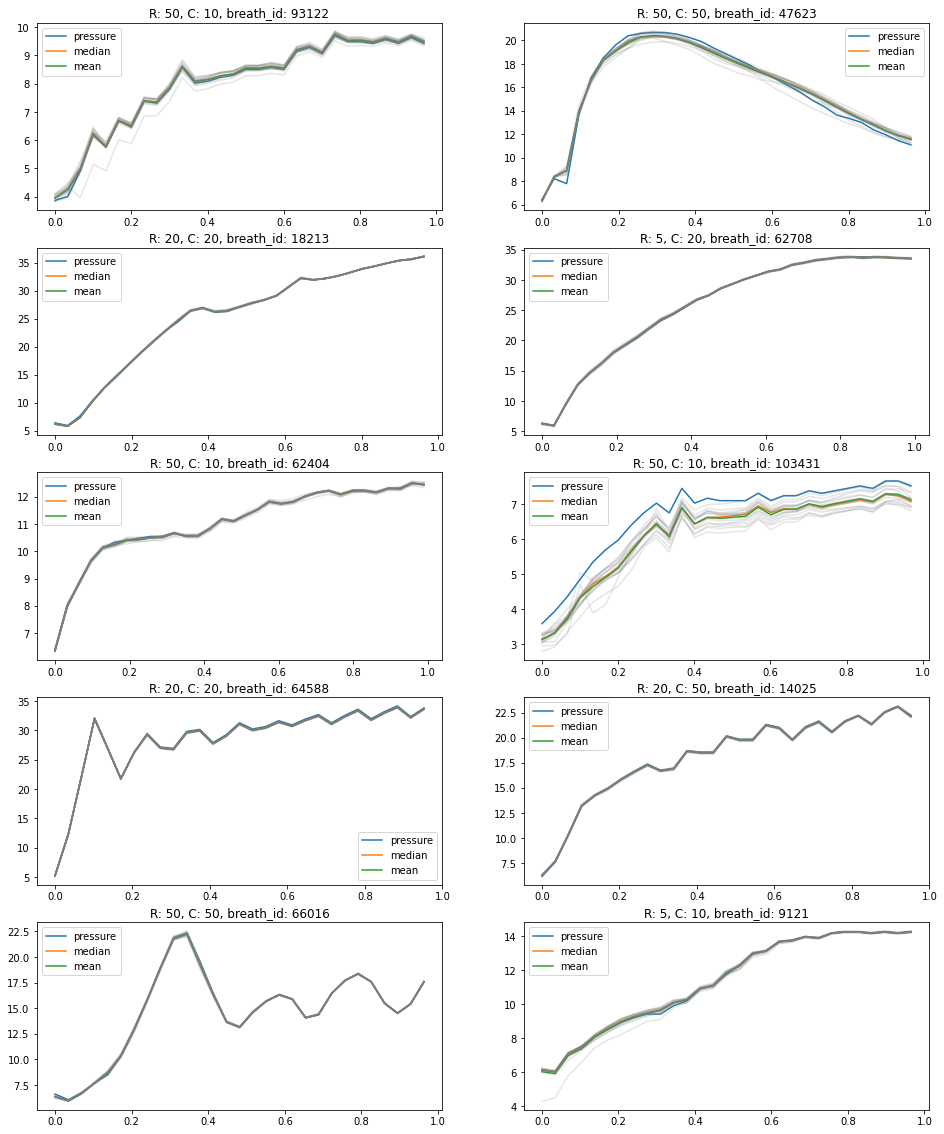

In [100]:
fig, ax = plt.subplots(5, 2, figsize=(16, 20))
worth_scores = []
for i in range(10):
    breath_id = random.choice(oof_df_b_ids)
    tmp_df = oof_df[oof_df['breath_id'] == breath_id].reset_index(drop=True)


    R = tmp_df.iloc[0, 2]
    C = tmp_df.iloc[0, 3]
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['median'], label='median')
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['mean'], label='mean')
    for j in range(oofs.shape[0]):
        ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df[f'oof_{j}'], color='gray', alpha=0.2)
    ax[int(i/2)][int(i%2)].set_title(f'R: {R}, C: {C}, breath_id: {breath_id}')
    ax[int(i/2)][int(i%2)].legend()
    

In [12]:
tmp_ranges = []
for oof_df_b_id in tqdm(oof_df_b_ids):

    tmp = oof_df[oof_df['breath_id']==oof_df_b_id].loc[:, 'oof_0':'oof_15']
    tmp_target = oof_df[oof_df['breath_id']==oof_df_b_id].loc[:, 'pressure']
    
    # 平均と標準偏差
    average = np.mean(tmp,axis=1)
    sd = np.std(tmp,axis=1)

    # 外れ値の基準点
    outlier_min = average - (sd) * 2
    outlier_max = average + (sd) * 2
    outlier_min = np.matlib.repmat(outlier_min,oofs.shape[0],1).T
    outlier_max = np.matlib.repmat(outlier_max,oofs.shape[0],1).T
    
    tmp_range = tmp[(tmp > outlier_min) & (tmp < outlier_max)]
    tmp_range = tmp_range.T.fillna(tmp_range.T.mean()).T
#     break
    
    tmp_ranges.append(tmp_range)

100%|██████████| 75450/75450 [11:31<00:00, 109.18it/s]


In [13]:
tmp_ranges_df = pd.concat(tmp_ranges)

In [14]:
np.median(tmp_ranges_df.values,axis=1).shape

(2290968,)

In [15]:
oof_median = np.median(oofs,axis=0)
print('simple median cv:',mae(targets, oof_median))

oof_median = np.median(tmp_ranges_df.values,axis=1)
print('simple median cv:',mae(targets, oof_median))

oof_median = np.mean(tmp_ranges_df.values,axis=1)
print('simple mean cv:',mae(targets, oof_median))

simple median cv: 0.12445581789121203
simple median cv: 0.12430833822224352
simple mean cv: 0.12596663047044265


In [107]:
oof_median = np.median(tmp,axis=1)
print('simple median cv:',mae(tmp_target, oof_median))

oof_median = np.median(tmp_range,axis=1)
print('simple median cv:',mae(tmp_target, oof_median))

simple median cv: 0.6066325915155473
simple median cv: 0.5998254478890176


In [10]:
mean = np.mean(oofs, axis=0)
med = np.median(oofs, axis=0)
std = np.std(oofs, axis=0)

In [11]:
q25 = np.percentile(oofs, axis=0, q=45)
q75 = np.percentile(oofs, axis=0, q=75)

In [12]:
clipped_pres = np.clip(np.vstack(oofs), q25, q75)
clipped_mean = np.mean(clipped_pres, axis=0)

In [13]:
clipped_mean_  = mae(targets, clipped_mean)
clipped_mean_

0.1259228042657319

In [14]:
oof = pd.DataFrame({'pred': clipped_mean})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
mae(targets, oof_pp)

0.12338812596052076

In [15]:
oof_var = np.var(oofs, axis=0)

In [16]:
rate = 0.3

In [17]:
mae(targets[oof_var < rate], oof_median[oof_var < rate])

0.11414809026406592

In [18]:
mae(targets[oof_var >= rate], oof_median[oof_var >= rate])

0.7150303840683367

In [19]:
oofs_worth = oofs[:, oof_var < rate]

In [20]:
print("the number of oof is", len(oofs_worth))

# medianでブレンドする
oof_mean = sum(oofs_worth) / len(oofs_worth)
print('simple mean cv:',mae(targets[oof_var < rate], oof_mean))

# medianでブレンドする
oof_median = np.median(np.vstack(oofs_worth),axis=0)
print('simple median cv:',mae(targets[oof_var < rate], oof_median))

# median pp
oof = pd.DataFrame({'pred': oof_median})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
score = mae(targets[oof_var < rate], oof_pp)
print(score)

the number of oof is 16
simple mean cv: 0.11534454393456493
simple median cv: 0.11414809026406592
0.11156050920075676


In [21]:
oofs_pp = []
for oof in oofs:
    oofs_pp.append(pd.Series(oof).map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()]).values)

In [22]:
oofs_pp = np.array(oofs_pp)

In [23]:
print("the number of oof is", len(oofs_pp))

# medianでブレンドする
oof_mean = sum(oofs_pp) / len(oofs_pp)
print('simple mean cv:',mae(targets, oof_mean))

# medianでブレンドする
oof_median = np.median(np.vstack(oofs_pp),axis=0)
print('simple median cv:',mae(targets, oof_median))

# median pp
oof = pd.DataFrame({'pred': oof_median})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
score = mae(targets, oof_pp)
print(score)

the number of oof is 16
simple mean cv: 0.12834821144714034
simple median cv: 0.12212673564872038
0.12213540462885876


In [30]:
unique_pressures = df_["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

def find_high(prediction):
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return upper_val

def find_low(prediction):
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val

In [31]:
oofs_pp_highlow = []
for oof in tqdm(oofs):
    oofs_pp_highlow.append(pd.Series(oof).apply(find_high).values)
    oofs_pp_highlow.append(pd.Series(oof).apply(find_low).values)

100%|██████████| 16/16 [02:37<00:00,  9.86s/it]


In [32]:
print("the number of oof is", len(oofs_pp_highlow))

# medianでブレンドする
oof_mean = sum(oofs_pp_highlow) / len(oofs_pp_highlow)
print('simple mean cv:',mae(targets, oof_mean))

# medianでブレンドする
oof_median = np.median(np.vstack(oofs_pp_highlow),axis=0)
print('simple median cv:',mae(targets, oof_median))

# median pp
oof = pd.DataFrame({'pred': oof_median})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
score = mae(targets, oof_pp)
print(score)

the number of oof is 32
simple mean cv: 0.12874099871780137
simple median cv: 0.12229333350065646
0.12230304582707721


In [12]:
oofs_pp = np.array(oofs_pp).astype(np.float16).T

In [17]:
oofs = np.array(oofs).astype(np.float16).T

In [18]:
X = oofs
y = df_['pressure']

In [37]:
lin_reg = RidgeCV(alphas=np.logspace(-3,10, 20))
lin_reg.fit(X, y)
pred = lin_reg.predict(X)
print(mae(y, pred))
print(f'Ensemble Weights: {lin_reg.coef_}')
print(f'Sum of weights: {sum(lin_reg.coef_)}')

0.12852646117400912
Ensemble Weights: [0.05741952 0.07320534 0.01420845 0.14834334 0.03528354 0.09322916
 0.06860712 0.13548226 0.00938034 0.01576069 0.07716455 0.06041021
 0.03426351 0.05918    0.00732778 0.11112971]
Sum of weights: 1.0003955367153325


In [28]:
oofs = np.hstack([oofs, pred.reshape(-1, 1)])

In [33]:
oofs = oofs.T

In [34]:
print("the number of oof is", len(oofs))

# medianでブレンドする
oof_mean = sum(oofs) / len(oofs)
print('simple mean cv:',mae(targets, oof_mean))

# medianでブレンドする
oof_median = np.median(np.vstack(oofs),axis=0)
print('simple median cv:',mae(targets, oof_median))

# median pp
oof = pd.DataFrame({'pred': oof_median})
oof_pp = oof['pred'].map(lambda x: unique_pressures[np.abs(unique_pressures-x).argmin()])
score = mae(targets, oof_pp)
print(score)

the number of oof is 17
simple mean cv: 0.12838101069916283
simple median cv: 0.12469604100254499
0.12218637516340776


In [43]:
_, counts = np.unique(oofs_pp, axis=1, return_counts=True)

In [37]:
counts = counts[counts < 20]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

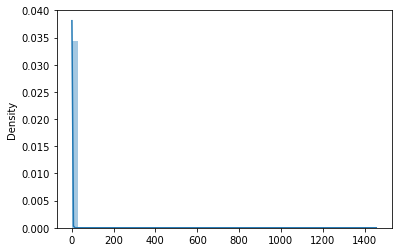

In [44]:
import seaborn as sns

sns.distplot(counts)

In [39]:
pd.Series(counts).describe()

count    2.223368e+06
mean     1.019816e+00
std      2.961538e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.900000e+01
dtype: float64

In [45]:
pd.Series(counts).value_counts()

1       2200628
2         15324
3          3554
4          1374
5           706
         ...   
98            1
100           1
103           1
112           1
1456          1
Length: 117, dtype: int64

In [7]:
oofs = np.array(oofs)

In [8]:
oof_var = np.var(oofs, axis=0)

In [9]:
rate = 0.05

In [10]:
mae(targets[oof_var < rate], oof_median[oof_var < rate])

0.09391977219910401

In [11]:
mae(targets[oof_var >= rate], oof_median[oof_var >= rate])

0.47079305719389125

In [12]:
mae(targets, oofs[7])

0.13949908339500636

In [13]:
mae(targets[oof_var >= rate], oofs[7][oof_var >= rate])

0.561485621697447

In [14]:
for oof in oofs:
    print(mae(targets[oof_var >= rate], oof[oof_var >= rate]), mae(targets[oof_var < rate], oof[oof_var < rate]))

0.6434548916471494 0.12399235781459815
0.6476017156435224 0.1262851546928113
0.6163003644958853 0.10608814184912453
0.5638637503355837 0.1107968494205847
0.611697131782161 0.10664243907552373
0.5829203300727472 0.11746364702176457
0.600331560672192 0.10837629931240676
0.561485621697447 0.1022931501231402
0.5816014426794255 0.11137584094230363
0.6408310119574182 0.11110037089307112
0.5926862873048593 0.10695805259334802
0.577360059587443 0.11167563352170551
0.6125736959577929 0.10646249003116054
0.5564475193814247 0.11340233938450231
0.6147207376662222 0.10618921230093212
0.5573543377511564 0.11137588750290833


In [15]:
oof_median_alt = np.median(oofs[[3, 11, 13, 15]],axis=0)

In [16]:
mae(targets[oof_var >= rate], oof_median_alt[oof_var >= rate])

0.5020030313948376

In [17]:
df_['ver'] = oof_var

In [18]:
df_[oof_var >= rate].value_counts('R_C')

R_C
50_50    43415
50_20    41188
50_10    33860
5_10     18393
20_10    15508
20_50    13383
20_20    10985
5_20      5264
5_50      3629
dtype: int64

In [19]:
len(df_[oof_var >= rate]) / len(df_)

0.08102470222194287

In [20]:
oofs = oofs[:, oof_var >= rate]

In [21]:
def objective(trial):
    
    ws = []
    oofs_ = []
    for i in range(len(oofs)):
        w_tmp = trial.suggest_int(f'w{i}', 0,15)
        ws.append(w_tmp)
        for _ in range(ws[i]):
            oofs_.append(oofs[i])
    oof = np.median(np.vstack(oofs_),axis=0)
    score = mae(targets[oof_var >= rate], oof)
    
    return score

In [23]:
%%time
optuna.logging.set_verbosity(verbosity=1) 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(paths)
print(study.best_params)
print(study.best_value)
print(list(study.best_params.values()))

[I 2021-10-25 00:50:45,247] A new study created in memory with name: no-name-6429bc99-d38d-49af-9a62-21751c0c1077
[I 2021-10-25 00:50:45,517] Trial 0 finished with value: 0.480574777225822 and parameters: {'w0': 10, 'w1': 5, 'w2': 8, 'w3': 0, 'w4': 2, 'w5': 4, 'w6': 5, 'w7': 3, 'w8': 2, 'w9': 12, 'w10': 13, 'w11': 7, 'w12': 12, 'w13': 15, 'w14': 0, 'w15': 13}. Best is trial 0 with value: 0.480574777225822.
[I 2021-10-25 00:50:45,814] Trial 1 finished with value: 0.47308978265948526 and parameters: {'w0': 4, 'w1': 12, 'w2': 4, 'w3': 4, 'w4': 8, 'w5': 4, 'w6': 6, 'w7': 11, 'w8': 12, 'w9': 4, 'w10': 11, 'w11': 2, 'w12': 3, 'w13': 13, 'w14': 9, 'w15': 14}. Best is trial 1 with value: 0.47308978265948526.
[I 2021-10-25 00:50:46,082] Trial 2 finished with value: 0.4815021699823994 and parameters: {'w0': 6, 'w1': 2, 'w2': 2, 'w3': 11, 'w4': 8, 'w5': 6, 'w6': 4, 'w7': 6, 'w8': 9, 'w9': 10, 'w10': 2, 'w11': 3, 'w12': 14, 'w13': 0, 'w14': 14, 'w15': 7}. Best is trial 1 with value: 0.473089782659

['/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/tea_oof_cv0.16608165493383653.csv', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/tea_oof_cv0.16852467380720984.csv', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/rt4kaido_oof_total_75.csv', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/yyama_oof_exp070.npy', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/rt4kaido_oof_total_77.csv', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/currypurin_177_oof.npy', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/currypurin_179_oof.npy', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/rt2kaido_oof_exp75_10folds.npy', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/yyama_oof_exp080.npy', '/home/knikaido/work/Ventilator-Pressure-Prediction/data/team_oofs/tea_oof_cv0.15402163834314866.csv', '/home/knikaido/work/Ventilator-Pres

In [20]:
weights_warui = [9, 5, 4, 15, 10, 13, 8, 15, 7, 11, 7, 12, 1, 14, 5, 5]
oofs_warui = oofs[:, oof_var >= 0.5]
oofs_warui_weightes = []
for i in range(len(oofs_warui)):
    for _ in range(weights_warui[i]):
        oofs_warui_weightes.append(oofs_warui[i])
oofs_warui_weightes = np.median(np.vstack(oofs_warui_weightes),axis=0)

In [21]:
weights_yoi = np.array([5, 10, 10, 10, 11, 11, 3, 15, 6, 13, 15, 7, 9, 11, 12, 8])
oofs_yoi = oofs[:, oof_var < 0.5]
oofs_yoi_weightes = []
for i in range(len(oofs_yoi)):
    for _ in range(weights_yoi[i]):
        oofs_yoi_weightes.append(oofs_yoi[i])
oofs_yoi_weightes = np.median(np.vstack(oofs_yoi_weightes),axis=0)

In [22]:
mae(np.hstack([targets[oof_var >= 0.5], targets[oof_var < 0.5]]), np.hstack([oofs_warui_weightes, oofs_yoi_weightes]))

0.12425772319009222

In [50]:
score = mae(targets[oof_var < 0.5], oofs_yoi_weight)
score

0.11723383112667962

In [ ]:
0.7558827246761815